In [45]:
import pickle
import matplotlib.pyplot as plt

In [46]:
with open('EloRatings.pkl', 'rb')as f:
    eloDict = pickle.load(f)

In [47]:
eloDict

{'Bethel': 1432.571963486864,
 'Goshen': 1450.385483229496,
 'Grace': 1485.8920376986255,
 'HU': 1542.013341082464,
 'IWU': 1557.7312585671455,
 'Marian': 1523.9959776208184,
 'MVNU': 1541.2211569401413,
 'SAU': 1495.8273064341213,
 'SFU': 1416.1551157644421,
 'Taylor': 1554.2063591758824}

In [48]:
def gamePlayed(winTeam, loseTeam, elo, winTeamLocation="N", marginOfVictory=1, k=20, tie=False): 
    if winTeamLocation == "H":
        rW = elo[winTeam] + 37.85 # get ratings
        rL = elo[loseTeam]
    elif winTeamLocation == "A":
        rW = elo[winTeam]
        rL = elo[loseTeam] + 37.85
    elif winTeamLocation == "N":
        rW = elo[winTeam]
        rL = elo[loseTeam]
    cW = 10 ** (rW/400)
    cL = 10 ** (rL/400)
    exp_winTeam = cW / float(cW + cL)
    exp_loseTeam = cL / float(cW + cL)
    if tie == True:
        s1 = 0.5
        s2 = 0.5
    else:
        s1 = 1
        s2 = 0
    if winTeamLocation == "H":
        new_rW = rW + k * (0.95 + 0.05*marginOfVictory) * (s1 - exp_winTeam) - 37.85
        new_rL = rL + k * (0.95 + 0.05*marginOfVictory) * (s2 - exp_loseTeam)
    elif winTeamLocation == "A":
        new_rW = rW + k * (0.95 + 0.05*marginOfVictory) * (s1 - exp_winTeam)
        new_rL = rL + k * (0.95 + 0.05*marginOfVictory) * (s2 - exp_loseTeam) - 37.85
    elif winTeamLocation == "N":
        new_rW = rW + k * (0.95 + 0.05*marginOfVictory) * (s1 - exp_winTeam)
        new_rL = rL + k * (0.95 + 0.05*marginOfVictory) * (s2 - exp_loseTeam)
    elo[winTeam] = new_rW
    elo[loseTeam] = new_rL

In [84]:
def expectGame(team1, team2, elo, Location1="N"):
    if type(team1) == str:
        if Location1 == "N" or Location1 == "A": r1 = elo[team1]
        elif Location1 == "H": r1 = elo[team1] + 37.85
    else:
        if Location1 == "N" or Location1 == "A": r1 = team1
        elif Location1 == "H": r1 = team1 + 37.85
    if type(team2) == str:
        if Location1 == "N" or Location1 == "H": r2 = elo[team2]
        elif Location1 == "A": r2 = elo[team2] + 37.85
    else:
        if Location1 == "N" or Location1 == "H": r2 = team2
        elif Location1 == "A": r2 = team2 + 37.85
    d = r1 - r2
    p = 1 - 1 / (1 + 10 ** (d / 400.0))
    return p

In [119]:
def simSeries(t1, t2, eloDict):
    elo = eloDict.copy()
    t1wins = dict.fromkeys([0,1,2,3,4], 0)
        # 1, 1, 1, 1
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[4] += p
    elo = eloDict.copy()
    
        # 1, 1, 1, 2
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[3] += p
    elo = eloDict.copy()
    
        # 1, 1, 2, 1
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[3] += p
    elo = eloDict.copy()
    
        # 1, 1, 2, 2
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[2] += p
    elo = eloDict.copy()
    
        # 1, 2, 1, 1
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[3] += p
    elo = eloDict.copy()
    
        # 1, 2, 1, 2
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[2] += p
    elo = eloDict.copy()
    
        # 1, 2, 2, 1
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[2] += p
    elo = eloDict.copy()
    
        # 1, 2, 2, 2
    p1 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[1] += p
    elo = eloDict.copy()
    
        # 2, 1, 1, 1
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[3] += p
    elo = eloDict.copy()
    
        # 2, 1, 1, 2
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[2] += p
    elo = eloDict.copy()
    
        # 2, 1, 2, 1
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[2] += p
    elo = eloDict.copy()
    
        # 2, 1, 2, 2
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[1] += p
    elo = eloDict.copy()
    
        # 2, 2, 1, 1
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[2] += p
    elo = eloDict.copy()
    
        # 2, 2, 1, 2
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t1, t2, elo)
    gamePlayed(t1, t2, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[1] += p
    elo = eloDict.copy()
    
        # 2, 2, 2, 1
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t1, t2, elo)
    p = p1*p2*p3*p4
    t1wins[1] += p
    elo = eloDict.copy()
    
        # 2, 2, 2, 2
    p1 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p2 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p3 = expectGame(t2, t1, elo)
    gamePlayed(t2, t1, elo)
    p4 = expectGame(t2, t1, elo)
    p = p1*p2*p3*p4
    t1wins[0] += p
    elo = eloDict.copy()
    
    return t1wins

In [120]:
GraceVsHU_sim = simSeries("Grace", "HU", eloDict)
print(GraceVsHU_sim)
print(sum(GraceVsHU_sim.values()))

{0: 0.1411313671961819, 1: 0.3115909344028579, 2: 0.3195642274527736, 3: 0.18041707338775143, 4: 0.047296397560435195}
1.0


In [121]:
def simSeriesBinomial(t1, t2, elo):
    t1wins = dict.fromkeys([0,1,2,3,4], 0)
    p = expectGame(t1, t2, elo)
    q = expectGame(t2, t1, elo)
    t1wins[0] = q**4
    t1wins[1] = 4*(p)*(q**3)
    t1wins[2] = 6*(p**2)*(q**2)
    t1wins[3] = 4*(p**3)*(q)
    t1wins[4] = p**4
    return t1wins

In [122]:
GraceVsHU = simSeriesBinomial("Grace","HU", eloDict)
GraceVsHU

{0: 0.11321949403565622,
 1: 0.327852079467709,
 2: 0.35601307087226325,
 3: 0.1718190944020027,
 4: 0.031096261222368856}

In [123]:
def winChart(team1, team2, binProbs):
    %matplotlib inline
    plt.style.use('ggplot')

    x = [0, 1, 2, 3, 4]
    probs = binProbs.values()

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, probs, color='black')
    plt.xlabel("Number of Wins")
    plt.ylabel("Probability")
    plt.title("Expected "+str(team1)+" Wins vs. "+str(team2))

    plt.xticks(x_pos, x)

    plt.show()

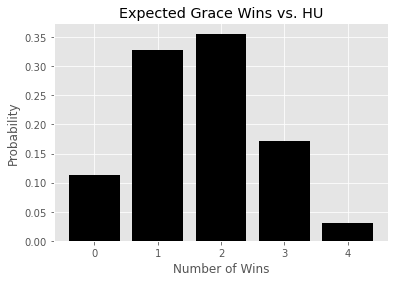

In [124]:
winChart("Grace","HU",GraceVsHU)

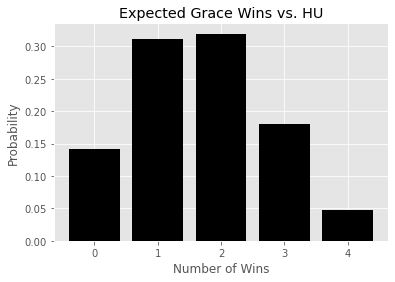

In [125]:
winChart("Grace","HU",GraceVsHU_sim)

In [126]:
expectGame("Grace", "HU", eloDict)

0.41993013732692974